In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset, concatenate_datasets
from scipy.spatial.distance import pdist,cdist, squareform
from sentence_transformers import SentenceTransformer

# Load the BBC News dataset
# Using Hugging Face version
dataset = load_dataset("SetFit/bbc-news")  # has 2,225 articles with the 5 labels. 
full_dataset = concatenate_datasets([dataset["train"], dataset["test"]])
texts = full_dataset["text"]
labels = full_dataset["label"]



In [ ]:
"""
# 2. Load a RoBERTa-based SentenceTransformer
model = SentenceTransformer("all-roberta-large-v1")

# 3. Encode texts (returns numpy array)
embeddings = model.encode(texts, batch_size=32, show_progress_bar=True)"""

import pickle

#with open("bbc_embeddings2225.pkl", "wb") as f:
#    pickle.dump(embeddings, f)

with open("bbc_embeddings2225.pkl", "rb") as f:
    embeddings = pickle.load(f)

'from sentence_transformers import SentenceTransformer\n\n# 2. Load a RoBERTa-based SentenceTransformer\nmodel = SentenceTransformer("all-roberta-large-v1")\n\n# 3. Encode texts (returns numpy array)\nembeddings = model.encode(texts, batch_size=32, show_progress_bar=True)'

In [232]:
X = embeddings
labels = np.array(labels)

In [254]:
X.shape

(2225, 1024)

In [233]:
tsne = TSNE(n_components=2)
pca = PCA(n_components=2)

X_tsne = tsne.fit_transform(X)
X_pca = pca.fit_transform(X)

In [234]:
X_poison = X.copy()
#labels_poison = labels_.copy()

from sklearn.cluster import KMeans



m = 220

for i in range(m):
    idx = np.random.choice(500, size=5, replace=False)
    mu = np.mean(X_poison[idx], axis=0)

    X_poison = np.concatenate((X_poison,[ mu  ]), axis=0)



X_tsne_poisoned = tsne.fit_transform(X_poison)

#X_pca_poisoned = pca.fit_transform(X_poison)





In [235]:
X_big_outliers = X.copy()
#labels_poison = labels_.copy()

from sklearn.cluster import KMeans
from tqdm import tqdm

# caclulates the diameter of a set of points
def diam(pts):
    return max(pdist(pts, metric='euclidean'))

m_big_outliers = 1100
"""
for i in tqdm(range(m_big_outliers)):
    outlier = np.random.normal(size=(X_big_outliers.shape[1])) 
    outlier /= np.linalg.norm(outlier)
    outlier *= 10*diam(X) + np.mean(X, axis=0)
    X_big_outliers = """
    
X_big_outliers = np.concatenate((X_big_outliers, np.array( np.random.normal(size=(m_big_outliers, X_big_outliers.shape[1]))  )), axis=0)



X_tsne_big_outliers = tsne.fit_transform(X_big_outliers)

#X_pca_big_outliers = pca.fit_transform(X_big_outliers)


In [236]:
X_big_outliers = X.copy()
#labels_poison = labels_.copy()

from sklearn.cluster import KMeans
from tqdm import tqdm

# caclulates the diameter of a set of points
def diam(pts):
    return max(pdist(pts, metric='euclidean'))

m_big_outliers = 1100

X_big_outliers = np.concatenate((X_big_outliers, np.array( np.random.normal(size=(m_big_outliers, X_big_outliers.shape[1]))  )), axis=0)



X_tsne_big_outliers = tsne.fit_transform(X_big_outliers)

#X_pca_big_outliers = pca.fit_transform(X_big_outliers)


In [237]:
X_tsne_big_outliers.shape

(3325, 2)

In [238]:
from sklearn.metrics import silhouette_score

SIL_orig = silhouette_score(X, labels)
SIL_tsne = silhouette_score(X_tsne, labels)
SIL_poisoned = silhouette_score(X_tsne_poisoned[:-m], labels)
SIL_outliers = silhouette_score(X_tsne_big_outliers[:-m_big_outliers], labels)

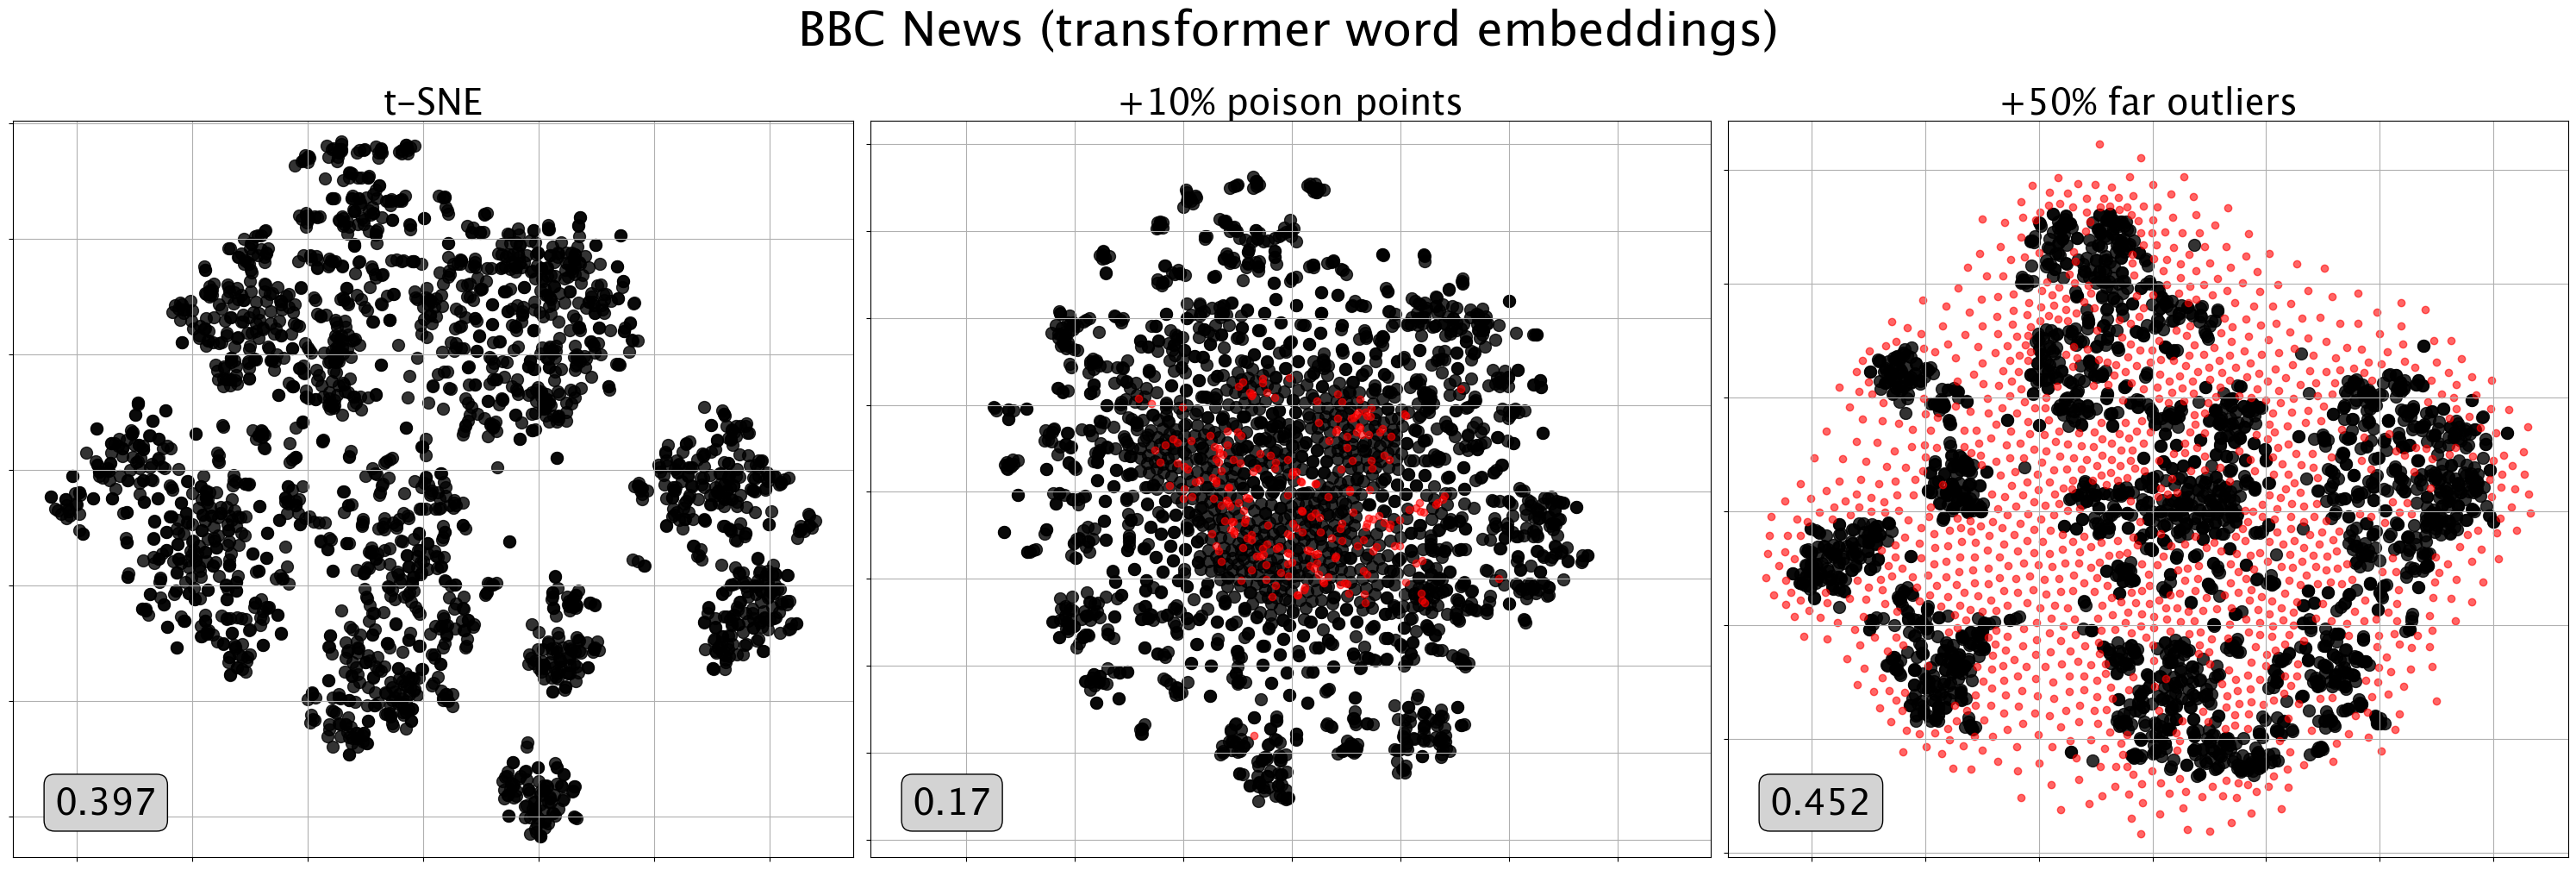

In [239]:
fig, axs = plt.subplots(1,3, figsize=(30,10))

for i in range(3):
    axs[i].grid('on')
    axs[i].axis('equal')
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])

axs[0].set_title('t-SNE', fontsize=30)
axs[0].scatter(X_tsne[:,0], X_tsne[:,1], c='black', s=100, alpha=0.8)
axs[0].text(0.05, 0.05, f"{SIL_tsne:.3g}",transform=axs[0].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=30, ha="left", va="bottom")

axs[1].set_title('+10% poison points', fontsize=30)
axs[1].scatter(X_tsne_poisoned[:-m,0], X_tsne_poisoned[:-m,1], c='black', s=100, alpha=0.8)
axs[1].scatter(X_tsne_poisoned[-m:,0], X_tsne_poisoned[-m:,1], c='red', alpha=0.6)
axs[1].text(0.05, 0.05, f"{SIL_poisoned:.3g}",transform=axs[1].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=30, ha="left", va="bottom")

axs[2].set_title('+50% far outliers', fontsize=30)
axs[2].scatter(X_tsne_big_outliers[:-m_big_outliers,0], X_tsne_big_outliers[:-m_big_outliers,1], s=100, c='black', alpha=0.8)
axs[2].scatter(X_tsne_big_outliers[-m_big_outliers:,0], X_tsne_big_outliers[-m_big_outliers:,1], c='red', alpha=0.6)
axs[2].text(0.05, 0.05, f"{SIL_outliers:.3g}",transform=axs[2].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=30, ha="left", va="bottom")
plt.suptitle('BBC News (transformer word embeddings)', fontsize=40, y=1.005)

plt.tight_layout()
plt.savefig('visuals/bbc/BBC_POISON.png', bbox_inches='tight')

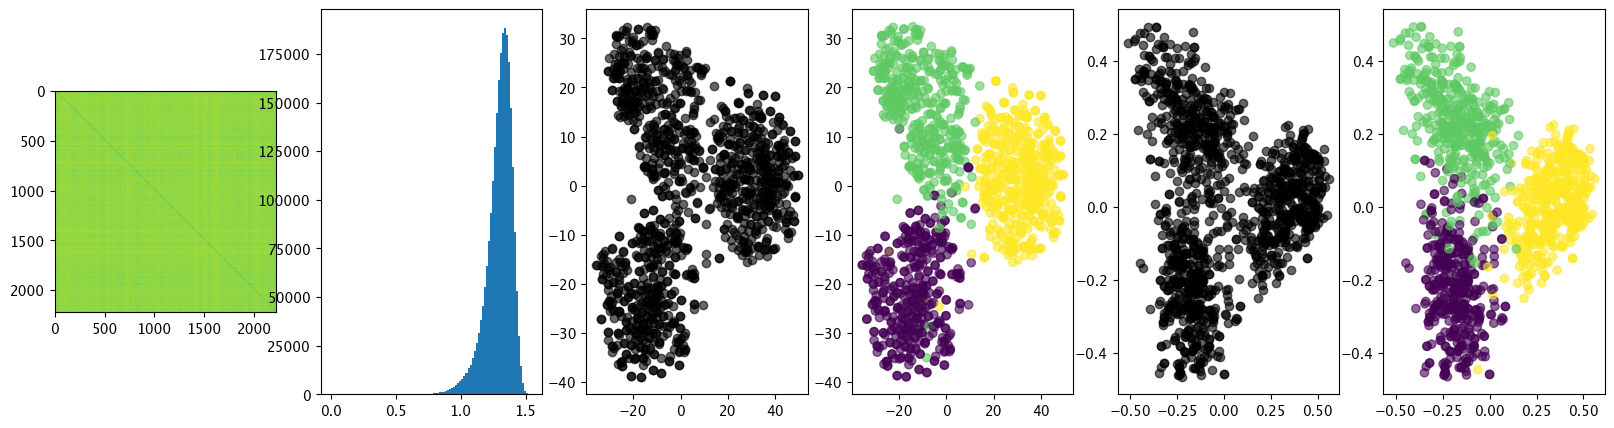

In [ ]:
from sklearn.decomposition import PCA

labels =np.array(labels)
ixs = np.where( (labels == 0) | (labels == 3) | (labels == 4) )
X_ = embeddings[ixs]
labels_ = labels[ixs]


tsne = TSNE(n_components=2, random_state=42, perplexity=70, n_iter=1000)
X_tsne_ = tsne.fit_transform(X_)#[new_ixs])

pca = PCA(n_components=2, random_state=42)
X_pca_ = pca.fit_transform(X_)

fig, axs = plt.subplots(1,6, figsize=(20,5))
distlist = pdist(embeddings)
axs[0].imshow(squareform(distlist))
axs[1].hist(distlist, bins=100)
axs[2].scatter(X_tsne_[:,0], X_tsne_[:,1], c='black', alpha=0.6)
axs[3].scatter(X_tsne_[:,0], X_tsne_[:,1], c=labels_, alpha=0.6)
axs[4].scatter(X_pca_[:,0], X_pca_[:,1], c='black', alpha=0.6)
axs[5].scatter(X_pca_[:,0], X_pca_[:,1], c=labels_, alpha=0.6)


In [ ]:
X_.shape

(1204, 1024)

In [241]:
X_poison_ = X_.copy()
#labels_poison = labels_.copy()

from sklearn.cluster import KMeans



m = 120

for i in range(m):
    idx = np.random.choice(500, size=5, replace=False)
    mu = np.mean(X_poison_[idx], axis=0)

    X_poison_ = np.concatenate((X_poison_,[ mu  ]), axis=0)



X_tsne_poisoned_ = tsne.fit_transform(X_poison_)
X_pca_poisoned_ = pca.fit_transform(X_poison_)





In [242]:
X_big_outliers_ = X_.copy()
#labels_poison = labels_.copy()

from sklearn.cluster import KMeans
from tqdm import tqdm

# caclulates the diameter of a set of points
def diam(pts):
    return max(pdist(pts, metric='euclidean'))

m_big_outliers = 120

X_big_outliers_ = np.concatenate((X_big_outliers_, np.array( np.random.normal(size=(m_big_outliers, X_big_outliers_.shape[1]))  )), axis=0)



X_tsne_big_outliers_ = tsne.fit_transform(X_big_outliers_)
X_pca_big_outliers_ = pca.fit_transform(X_big_outliers_)


In [243]:
from sklearn.metrics import silhouette_score
### silhouette score of t-sne
print('silhouette score, real', silhouette_score(X_, labels_))

print('silhouette score, tsne', silhouette_score(X_tsne_, labels_))
print('silhouette score, pca', silhouette_score(X_pca_, labels_))
SIL_TSNE_ = silhouette_score(X_tsne_, labels_)
SIL_PCA_ = silhouette_score(X_pca_, labels_)

print('silhouette score, tsne poisoned', silhouette_score(X_tsne_poisoned_[:-m], labels_))
print('silhouette score, pca poisoned', silhouette_score(X_pca_poisoned_[:-m], labels_))
SIL_TSNE_POISONED_ = silhouette_score(X_tsne_poisoned_[:-m], labels_)
SIL_PCA_POISONED_ = silhouette_score(X_pca_poisoned_[:-m], labels_)

print('silhouette score, tsne big outliers', silhouette_score(X_tsne_big_outliers_[:-m_big_outliers], labels_))
print('silhouette score, pca big outliers', silhouette_score(X_pca_big_outliers_[:-m_big_outliers], labels_))
SIL_TSNE_OUTLIERS = silhouette_score(X_tsne_big_outliers_[:-m_big_outliers], labels_)
SIL_PCA_OUTLIERS = silhouette_score(X_pca_big_outliers_[:-m_big_outliers], labels_)

silhouette score, real 0.07897649
silhouette score, tsne 0.548478
silhouette score, pca 0.5558449
silhouette score, tsne poisoned 0.32810724
silhouette score, pca poisoned 0.55570555
silhouette score, tsne big outliers 0.47790426
silhouette score, pca big outliers -0.025585638503493977


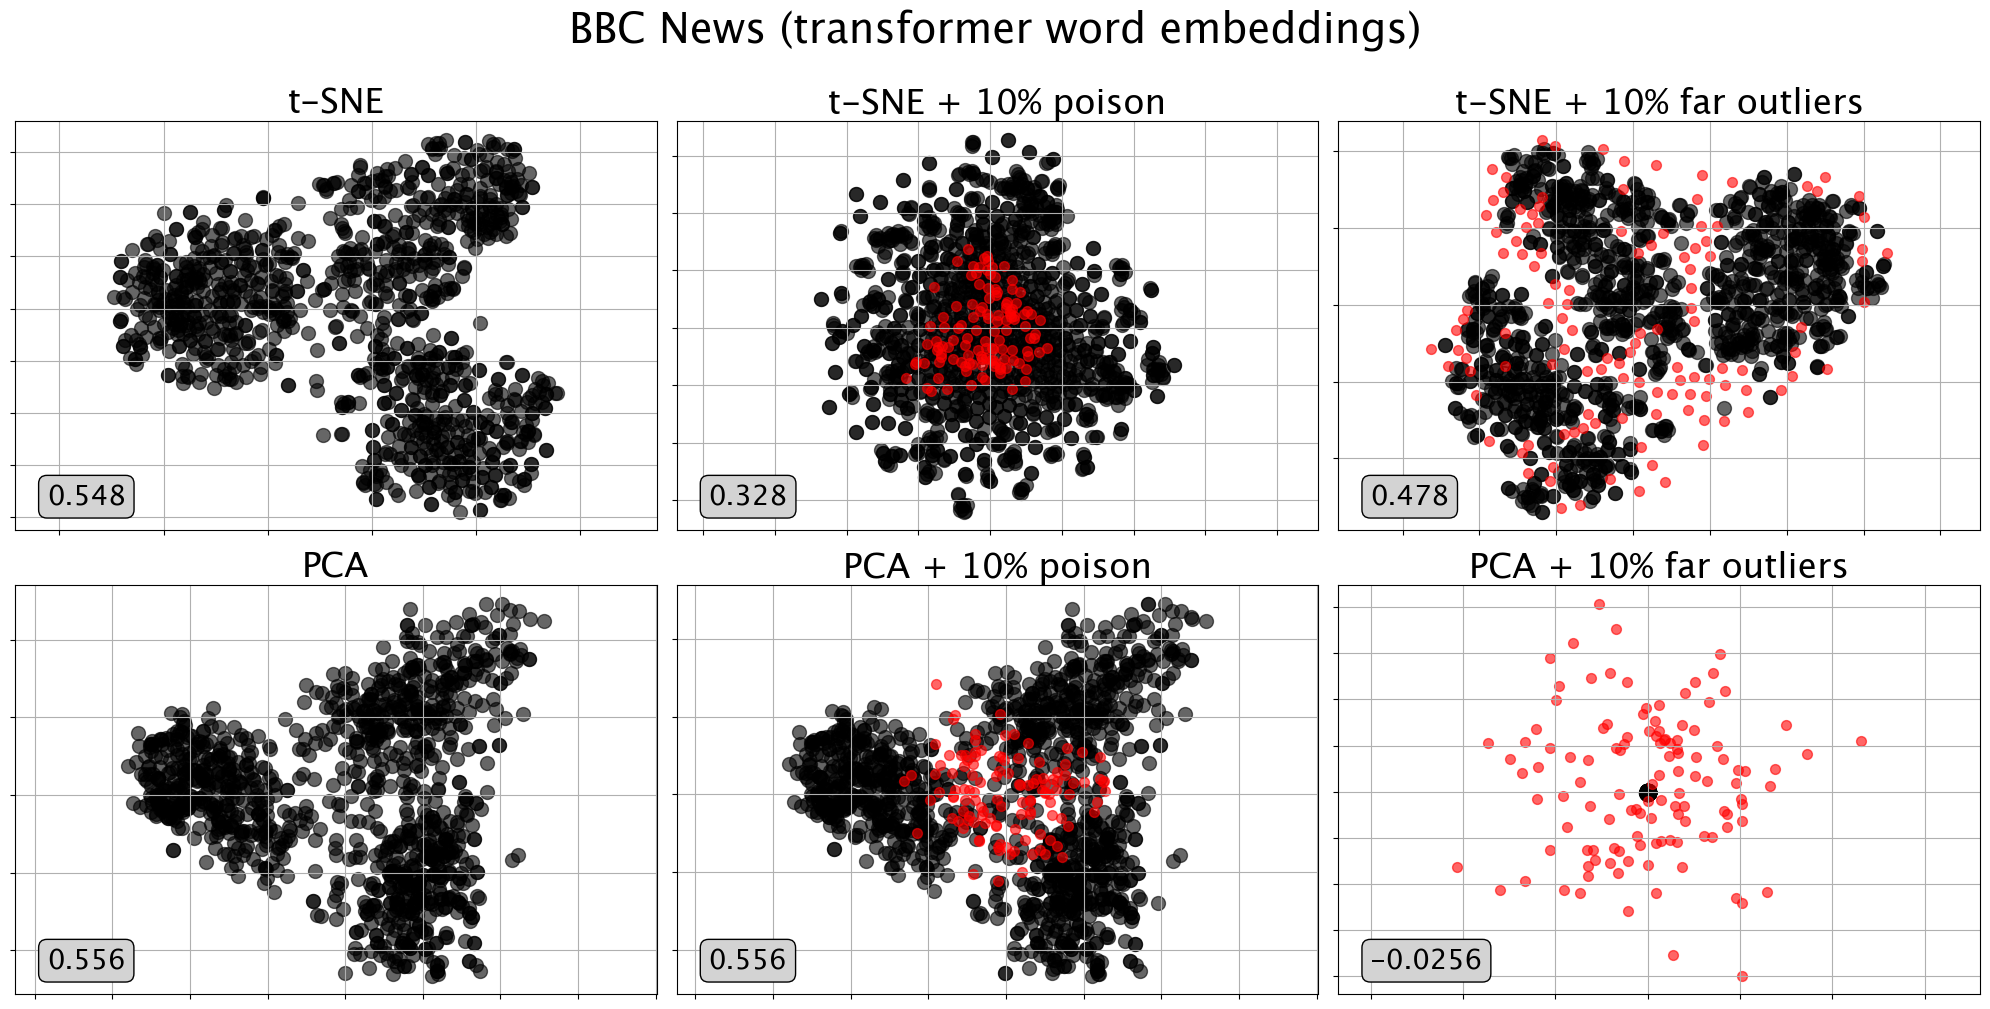

In [253]:
fig, axs = plt.subplots(2,3, figsize=(20,10))

blacksize = 100
redsize = 50

label_fontsize = 20

title_fontsize = 25

for i in range(2):
    for j in range(3):
        axs[i,j].grid('on')
        axs[i,j].axis('equal')
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])


axs[0,0].set_title('t-SNE', fontsize=title_fontsize)
axs[0,0].scatter(-X_tsne_[:-m,0], X_tsne_[:-m,1], c='black', alpha=0.6, s=blacksize)
axs[0,0].text(0.05, 0.05, f"{SIL_TSNE_:.3g}",transform=axs[0,0].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=label_fontsize, ha="left", va="bottom")

axs[0,1].set_title('t-SNE + 10% poison', fontsize=title_fontsize)
axs[0,1].scatter(-X_tsne_poisoned_[:-m,0], X_tsne_poisoned_[:-m,1], c='black', alpha=0.6, s=blacksize)
axs[0,1].scatter(X_tsne_poisoned_[-m:,0], X_tsne_poisoned_[-m:,1], c='red', alpha=0.6,s=redsize)
axs[0,1].text(0.05, 0.05, f"{SIL_TSNE_POISONED_:.3g}",transform=axs[0,1].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=label_fontsize, ha="left", va="bottom")

axs[0,2].set_title('t-SNE + 10% far outliers', fontsize=title_fontsize)
axs[0,2].scatter(X_tsne_big_outliers_[:-m_big_outliers,0], X_tsne_big_outliers_[:-m_big_outliers,1], c='black', alpha=0.6, s=blacksize)
axs[0,2].scatter(X_tsne_big_outliers_[-m_big_outliers:,0], X_tsne_big_outliers_[-m_big_outliers:,1], c='red', alpha=0.6, s=redsize)
axs[0,2].text(0.05, 0.05, f"{SIL_TSNE_OUTLIERS:.3g}",transform=axs[0,2].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=label_fontsize, ha="left", va="bottom")



axs[1,0].set_title('PCA', fontsize=title_fontsize)
axs[1,0].scatter(-X_pca_[:-m,0], X_pca_[:-m,1], c='black', alpha=0.6, s=blacksize)
axs[1,0].text(0.05, 0.05, f"{SIL_PCA_:.3g}",transform=axs[1,0].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=label_fontsize, ha="left", va="bottom")

axs[1,1].set_title('PCA + 10% poison', fontsize=title_fontsize)
axs[1,1].scatter(-X_pca_poisoned_[:-m,0], X_pca_poisoned_[:-m,1], c='black', alpha=0.6, s=blacksize)
axs[1,1].scatter(X_pca_poisoned_[-m:,0], X_pca_poisoned_[-m:,1], c='red', alpha=0.6,s=redsize)
axs[1,1].text(0.05, 0.05, f"{SIL_PCA_POISONED_:.3g}",transform=axs[1,1].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=label_fontsize, ha="left", va="bottom")

axs[1,2].set_title('PCA + 10% far outliers', fontsize=title_fontsize)
axs[1,2].scatter(X_pca_big_outliers_[:-m_big_outliers,0], X_pca_big_outliers_[:-m_big_outliers,1], c='black', alpha=0.6, s=blacksize)
axs[1,2].scatter(X_pca_big_outliers_[-m_big_outliers:,0], X_pca_big_outliers_[-m_big_outliers:,1], c='red', alpha=0.6,s=redsize)
axs[1,2].text(0.05, 0.05, f"{SIL_PCA_OUTLIERS:.3g}",transform=axs[1,2].transAxes, 
              bbox=dict(facecolor="lightgrey", edgecolor="black", boxstyle="round,pad=0.3"),
              fontsize=label_fontsize, ha="left", va="bottom")

plt.suptitle('BBC News (transformer word embeddings)', fontsize=30, y=1.005)
plt.tight_layout()
plt.savefig('visuals/bbc/bbc_appendix.png',  bbox_inches='tight')